In [ ]:
''' 
- Solve with more stuff and maybe a reaction too
- check if you use just perimeter is that works for the heat in the big file
- CHECK IF YOUR MASS CONSERVATION EUQUATION IS EVEN RIGHT WITH THE PERIMETER THING
'''

from scipy.integrate import solve_bvp
import numpy as np
import matplotlib.pyplot as plt

In [134]:
def heats(T):
    #heats of reaction and heat capacity calculation from NIST
    t = T/1000

    #CH4
    A =	-0.703029
    B =	108.4773
    C =	-42.52157
    D =	5.862788
    E =	0.678565
    F =	-76.84376
    G =	158.7163
    H =	-74.87310

    dH_CH4 = A*t + B*t**2/2 + C*t**3/3 + D*t**4/4 - E/t + F - H
    Cp_CH4 = A + B*t + C*t**2 + D*t**3 + E/(t**2)

    #H2O
    A =   30.09200
    B =   6.832514
    C =   6.793435
    D =  -2.534480
    E =   0.082139
    F =  -250.8810
    G =   223.3967
    H =  -241.8264

    dH_H2O = A*t + B*t**2/2 + C*t**3/3 + D*t**4/4 - E/t + F - H
    Cp_H2O = A + B*t + C*t**2 + D*t**3 + E/(t**2)

    #CO
    A =   25.56759
    B =   6.096130
    C =   4.054656
    D =  -2.671301
    E =   0.131021
    F =  -118.0089
    G =   227.3665
    H = -110.5271

    dH_CO = A*t + B*t**2/2 + C*t**3/3 + D*t**4/4 - E/t + F - H
    Cp_CO = A + B*t + C*t**2 + D*t**3 + E/(t**2)

    #CO2
    A =   24.99735
    B =   55.18696
    C =  -33.69137
    D =   7.948387
    E =  -0.136638
    F =  -403.6075
    G =   228.2431
    H =  -393.5224

    dH_CO2 = A*t + B*t**2/2 + C*t**3/3 + D*t**4/4 - E/t + F - H
    Cp_CO2 = A + B*t + C*t**2 + D*t**3 + E/(t**2)

    #H2
    A =  33.066178
    B = -11.363417
    C =  11.432816
    D = -2.772874
    E = -0.158558
    F = -9.980797
    G =  172.707974
    H =  0.0

    dH_H2 = A*t + B*t**2/2 + C*t**3/3 + D*t**4/4 - E/t + F - H
    Cp_H2 = A + B*t + C*t**2 + D*t**3 + E/(t**2)

    #Ar
    A =	20.78600
    B =	2.825911*10**-7
    C =	-1.464191*10**-7
    D =	1.092131*10**-8
    E =	-3.661371*10**-8
    F =	-6.197350
    G =	179.9990
    H =	0

    dH_Ar = A*t + B*t**2/2 + C*t**3/3 + D*t**4/4 - E/t + F - H
    Cp_Ar = A + B*t + C*t**2 + D*t**3 + E/(t**2) #J/mol K

    dHsmr = (3*dH_H2 + dH_CO - dH_CH4 - dH_H2O + 206.1)*10**3 #J/mol
    dHwgs = (dH_H2 + dH_CO2 - dH_CO - dH_H2O - 41.15)*10**3 #J/mol
    # print(dHsmr)
    # print(dHwgs)
    # print([Cp_CH4, Cp_H2O, Cp_CO, Cp_CO2, Cp_H2])
    return dHsmr, dHwgs, [Cp_CH4, Cp_H2O, Cp_CO, Cp_CO2, Cp_H2, Cp_Ar], [dH_CH4, dH_H2O, dH_CO, dH_CO2, dH_H2, dH_Ar]

In [135]:
#F*Cp*dT = q_surr''*Peri*dx = U(Ts - T)*Peri*dx       U is heat transfer coeff W/m2 K
L = 1 #m
R = 0.25 #m
Peri = 2*np.pi*R #m

Tin = 400 #K
Ts = 298 #k

U = 20 #W/m2k
q = 10000 #W/m2

F = 1 #mol/s

Cp = 34.5

In [136]:
x_num = 1000
dx = L/(x_num-1)
x_pts = np.linspace(0,L,x_num)


ig = np.full((1, x_num), Tin)

# ODE function: dT/dx = q*Peri / (F*Cp)
def ode(x, T):
    _, _, Cps, _ = heats(T[0])
    Cp = Cps[1]
    dTdx = U*(-T+Ts)*Peri/(F*Cp) + q*Peri/(F*Cp)
    return dTdx

def bc(yleft, yright):
    return np.array([yleft[0]-Tin])

soln = solve_bvp(ode, bc, x_pts, ig, max_nodes=x_num, tol = 0.001)


Text(0, 0.5, 'T (K)')

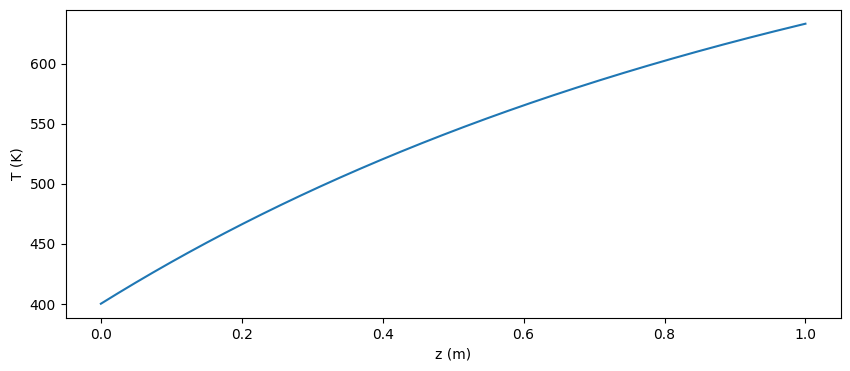

In [137]:
plt.figure(figsize=(10, 4))
plt.plot(soln.x, soln.y[0])
plt.xlabel('z (m)')
plt.ylabel('T (K)')

In [138]:
#Enthalpy balance based on heats of formation
_, _, Cpin, heatsin = heats(soln.y[0,0]) #kJ/mol
_, _, Cpout, heatsout = heats(soln.y[0,-1]) #kJ/mol

dx = L/(x_num-1)

Qarray = U*(-soln.y[0]+Ts)*Peri*dx + q*Peri*dx
Q = np.sum(Qarray)

Hin = (heatsin[1] + -241.8)*10**3 * F
Hout = (heatsout[1] + -241.8)*10**3 * F

dH = Hout-Hin
print(f'{dH:.3} W')
print(f'{Q:.3} W')
print(f'heat balance off by {abs(dH - Q)/Q *100:.4}%')

8.26e+03 W
8.27e+03 W
heat balance off by 0.107%


In [139]:
#Enthalpy balance based on heats of formation
_, _, Cpin, heatsin = heats(soln.y[0,0]) #kJ/mol
_, _, Cpout, heatsout = heats(soln.y[0,-1]) #kJ/mol

dx = L/(x_num-1)

Qarray = U*(-soln.y[0]+Ts)*Peri*dx + q*Peri*dx
Q = np.sum(Qarray)

Hin = (heatsin[1] + 9.904)*10**3 * F
Hout = (heatsout[1] + 9.904)*10**3 * F

dH = Hout-Hin
print(f'{dH:.3} W')
print(f'{Q:.3} W')
print(f'heat balance off by {abs(dH - Q)/Q *100:.4}%')

8.26e+03 W
8.27e+03 W
heat balance off by 0.107%
